In [1]:
import torch
import torch.nn as nn
import torch_geometric
from src.layer.encoders import TrigonometricEncoder
from src.model.wavegc import WaveGCNet
from src.transforms.spectral import WaveGCSpectralTransform

import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: >

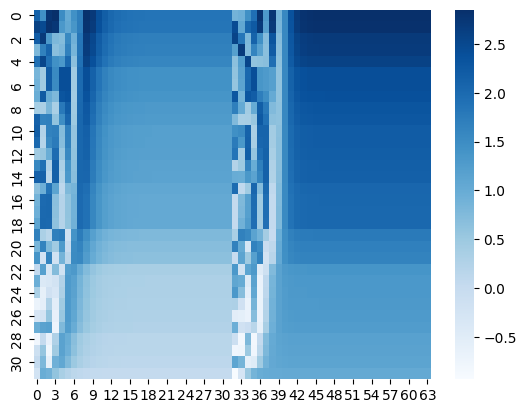

In [2]:
eigvs = torch.tensor(np.random.uniform(0,2, (1, 32) ),
                      dtype=torch.float32).sort(
    axis=1,descending=True).values
d = 64

pe = TrigonometricEncoder(d, 100, project=False)
pos = pe(eigvs)
sns.heatmap(pos.detach(), cmap='Blues')

In [ ]:
from src.datasets.amazon import AmazonComputerDataset
from src.datasets.Ps import PeptidesStructDataset
from torch_geometric.utils.convert import to_networkx, from_networkx
import networkx as nx

In [4]:
dataset = AmazonComputerDataset(root='./data', name='Photo', threshold=0)

In [5]:
G = to_networkx(dataset._data)
G = nx.to_undirected(G)
nx.number_connected_components(G)

136

In [6]:
components = nx.connected_components(G)
for comp in components:
    print(len(comp)/G.number_of_nodes())

0.9786928104575163
0.00026143790849673205
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00026143790849673205
0.00013071895424836603
0.00026143790849673205
0.00013071895424836603
0.0005228758169934641
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00026143790849673205
0.00026143790849673205
0.00026143790849673205
0.00013071895424836603
0.00026143790849673205
0.00026143790849673205
0.00013071895424836603
0.000392156862745098
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00026143790849673205
0.00013071895424836603
0.00013071895424836603
0.0005228758169934641
0.00013071895424836603
0.00026143790849673205
0.0005228758169934641
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.000130718954248366

In [7]:
from torch.utils.data import DataLoader
from src.datasets.collate import collate_fn

In [9]:
loader = DataLoader(dataset=dataset, collate_fn=collate_fn, batch_size=1)

In [11]:
inp_dim = dataset._data.x.shape[1]
emb_dim, pe_dim = 32, 16
eigvs_dim = dataset._data.eigvs.shape[1]
hidden_dim = 32
lape_hidden_num = 1
out_dim = dataset._data.y.unique().shape[0]
K, J = 6, 3

In [12]:
import torch.nn as nn
import torch_geometric.nn as pyg_nn
from torch_geometric.nn.conv import MessagePassing

class SimpleGCN(nn.Module):
    def __init__(self, inp_dim, out_dim, hidden_dim, hidden_num=3, **kwargs):
        super().__init__()
        self.inp_dim, self.out_dim = inp_dim, out_dim
        self.hidden_dim = hidden_dim
        act = nn.GELU
        self.conv = nn.ModuleList([pyg_nn.GCN(
                                    in_channels=inp_dim,
                                    hidden_channels=hidden_dim,
                                    num_layers=hidden_num,
                                    act = act(),
                                )])
        for i in range(hidden_num):
            self.conv.append( pyg_nn.GCN(
                    in_channels=hidden_dim,
                    hidden_channels=hidden_dim,
                    num_layers=3,
                    act = act())
            )
            if i!= hidden_num-1:
                self.conv.append(nn.BatchNorm1d(hidden_dim))
                #self.conv.append(act())
        self.out = nn.Linear(hidden_dim, out_dim)
        
    def forward(self, x, edge_index, **kwargs):
        for module in self.conv: 
            if isinstance(module, (pyg_nn.GCN, MessagePassing)): 
                x = module(x, edge_index)
            else:
                x = module(x) 
                
        return self.out(x)


In [13]:
import hydra
print(hydra.__version__)

1.3.2


In [14]:
wave_flag = True

In [15]:
model = WaveGCNet(
        inp_dim=inp_dim,
        out_dim=out_dim,
        emb_dim=emb_dim, 
        pe_dim=pe_dim, 
        eigvs_dim=eigvs_dim,
        lape_hidden_num=lape_hidden_num,
        hidden_dim=hidden_dim, 
        heads_num=4,
        scale=torch.tensor([1.0]*J), 
        num_layers=4,
        mpnn="gcn",
        K=K,
        J=J,
        tight_frames=True,
        dropout=0.2,
        ffn_hidden_num=2,
        mpnn_hidden_num=1,
        eps=100,
        aggr="sum",
    ) if wave_flag else SimpleGCN(inp_dim, out_dim, hidden_dim=64)

In [16]:
print("Number of Parameters: ", sum([param.numel() for param in model.parameters()]))

Number of Parameters:  124345


In [2]:
dataset = PeptidesStructDataset(root='./data')

Extracting data/peptidesstruct.zip
Processing...
Processing train dataset:   0%|          | 0/10873 [00:00<?, ?it/s]


RuntimeError: result type Float can't be cast to the desired output type Long